## Application of BPR on Movielens

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import matplotlib.pyplot as plt
from functools import partial

## Prepare data

In [3]:
%%time
#df = load_movielens_data('ml-1m')
df = load_movielens_data(
    data_dir = os.path.join(os.path.curdir, 'data'),
    flag = 'ml-100k'
)
df.head()

CPU times: user 14.1 ms, sys: 5.45 ms, total: 19.6 ms
Wall time: 19.5 ms


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# rating more than or equal to 3 as positive
df_pos = df[df['rating'] > 2].copy()
df_neg = df[df['rating'] <= 2].copy()
df, [df_pos, df_neg] = generate_user_item_indices(parent_df=df, children_dfs=[df_pos, df_neg])

In [5]:
# df_pos[df_pos.user_idx==45], df_neg[df_neg.user_idx==45]
# df_pos[df_pos.item_idx==45], df_neg[df_neg.item_idx==45]

In [6]:
mldata_pos = UserItemInteractions(
    name='MovieLens-100k-pos',
    users_index=df_pos['user_idx'],
    items_index=df_pos['item_idx'],
    num_items=df.item_idx.nunique(),
    num_users=df.user_idx.nunique()
)
mldata_pos.generate_train_test(user_test_ratio=0.2)

mldata_neg = UserItemInteractions(
    name='MovieLens-100k-neg',
    users_index=df_neg['user_idx'],
    items_index=df_neg['item_idx'],
    num_items=df.item_idx.nunique(),
    num_users=df.user_idx.nunique()
)
mldata_neg.generate_train_test(user_test_ratio=0.2)



----UserItemInteractions--MovieLens-100k-pos
# of users (active/total): 943/943
# of items (active/total): 1574/1682
# of interactions: 82520
Sparsity in the UI mat: 0.052026
Memory used by sparse UI mat: 0.08 MB
Generating train-test split..done

----UserItemInteractions--MovieLens-100k-neg
# of users (active/total): 915/943
# of items (active/total): 1548/1682
# of interactions: 17480
Sparsity in the UI mat: 0.011021
Memory used by sparse UI mat: 0.02 MB
Generating train-test split..done


## Define BPR and negative sampler

In [7]:
bpr1 = BPR(
    num_features=50, # not benefit more than 50
    reg_lambda=0.01,
    num_iters=200,
    learning_rate = 0.03,
    batch_size=1000,
    initial_std=0.001,
)
bpr1.initiate(num_users=mldata_pos.num_users, num_items=mldata_pos.num_items, seed=1234)

Setting batch size to 943


In [8]:
metric_log_train = []
metric_log_test = []
for _ in range(100):
    neg_sampler = partial(
        uniform_negative_sampler, 
        uimat=mldata_pos.mat_train
    )
    results = bpr_fit(
        bpr_obj=bpr1, 
        neg_sampler=neg_sampler, 
        ncores=104
    )
    mfunc = partial(
        bpr1.get_metric_v1,
        perc_active_users=0.99,
        perc_active_items=0.99,
        num_recs=20
    )
    metric_log_train.append(mfunc(uimat=mldata_pos.mat_train))
    metric_log_test.append(mfunc(uimat=mldata_pos.mat_test))
metric_log_train = np.asarray(metric_log_train)
metric_log_test = np.asarray(metric_log_test)

BPR-Fit: 100%|██████████| 188600/188600 [00:00<00:00, 244731.53it/s]


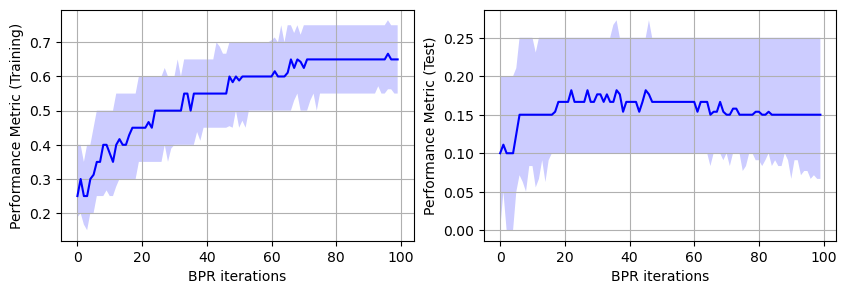

In [9]:
xgrid = np.arange(0,metric_log_train.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(metric_log_train[:,1], '-b')
ax[0].fill_between(xgrid, metric_log_train[:,0], metric_log_train[:,2], color='b', alpha=0.2, ec=None)
ax[0].set_ylabel('Performance Metric (Training)')


ax[1].plot(metric_log_test[:,1], '-b')
ax[1].fill_between(xgrid, metric_log_test[:,0], metric_log_test[:,2], color='b', alpha=0.2, ec=None)
ax[1].set_ylabel('Performance Metric (Test)')

for iax in ax:
    iax.grid(True)
    iax.set_xlabel('BPR iterations')